In [0]:
# Import necessary libraries
from pyspark.sql.functions import col, current_timestamp, when, count, isnan
from pyspark.sql import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define variables for file paths and table names
file_path = "/databricks-datasets/structured-streaming/events"  # Source data path
username = spark.sql("SELECT regexp_replace(current_user(), '[^a-zA-Z0-9]', '_')").first()[0]
table_name = f"{username}_etl_quickstart"  # Table name for storing transformed data
checkpoint_path = f"/tmp/{username}/_checkpoint/etl_quickstart"  # Checkpoint path for data consistency

# Function to clear out data from previous executions (for idempotency)
def clear_previous_data(table_name, checkpoint_path):
    try:
        spark.sql(f"DROP TABLE IF EXISTS {table_name}")
        dbutils.fs.rm(checkpoint_path, True)
    except Exception as e:
        print(f"Error in clearing previous data: {e}")

# Call the function to clear previous data
clear_previous_data(table_name, checkpoint_path)

# Configure Auto Loader to ingest JSON data to a Delta table with error handling
try:
    (spark.readStream
      .format("cloudFiles")
      .option("cloudFiles.format", "json")
      .option("cloudFiles.schemaLocation", checkpoint_path)
      .load(file_path)
      .select("*", col("_metadata.file_path").alias("source_file"), current_timestamp().alias("processing_time"))
      .writeStream
      .option("checkpointLocation", checkpoint_path)
      .trigger(availableNow=True)
      .toTable(table_name))
except Exception as e:
    print(f"Error in ETL process: {e}")

In [0]:
# Read data from the Delta table
df = spark.read.table(table_name)

In [0]:
# Data Validation - Null Values, Data Types, and Value Ranges
columns_to_check = ['action', 'time', 'source_file']  # Update as per your data schema

def validate_null_values(df, columns):
    for column in columns:
        df = df.withColumn(f"{column}_valid", when(col(column).isNull(), "Invalid").otherwise("Valid"))
    return df

df = validate_null_values(df, columns_to_check)
df = df.withColumn("time_type_valid", when(col("time").cast("Timestamp").isNull(), "Invalid").otherwise("Valid"))
df = df.withColumn("action_type_valid", when(col("action").cast("String").isNull(), "Invalid").otherwise("Valid"))

# Example range check (adjust as needed)
df = df.withColumn("time_range_valid", when((col("time") < "some_start_date") | (col("time") > "some_end_date"), "Invalid").otherwise("Valid"))

display(df)

action time _rescued_data source_file processing_time action_valid time_valid source_file_valid time_type_valid action_type_valid time_range_valid Close 1469546337 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Open 1469546351 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Open 1469546354 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Open 1469546356 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Open 1469546362 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Close 1469546365 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Close 1469546366 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Open 1469546366 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Open 1469546369 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Close 1469546373 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Close 1469546373 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Open 1469546373 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Open 1469546373 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Close 1469546374 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Close 1469546374 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Open 1469546374 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Close 1469546376 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Close 1469546379 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Close 1469546380 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Open 1469546382 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Close 1469546383 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Open 1469546383 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Close 1469546388 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Open 1469546388 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Open 1469546392 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid Invalid Close 1469546393 null /databricks-datasets/structured-streaming/events/file-12.json 2023-11-20T01:46:17.029Z Valid Valid Valid Invalid Valid 

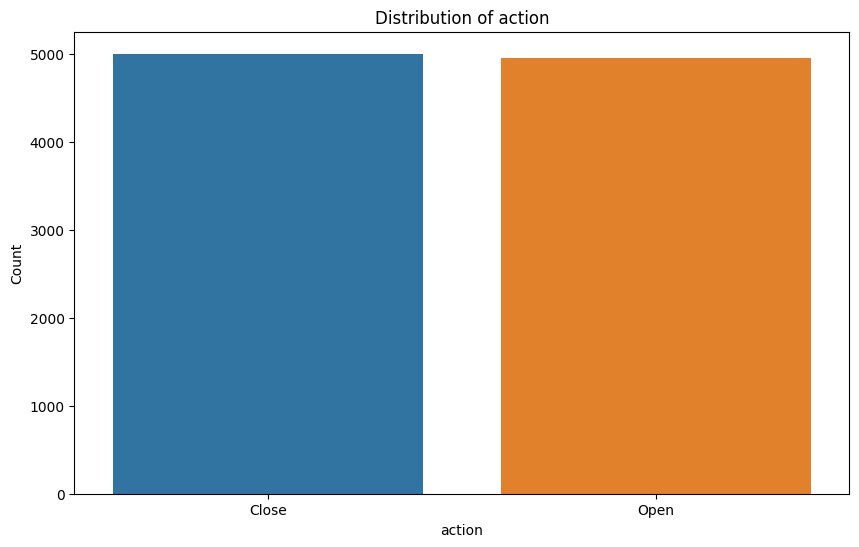

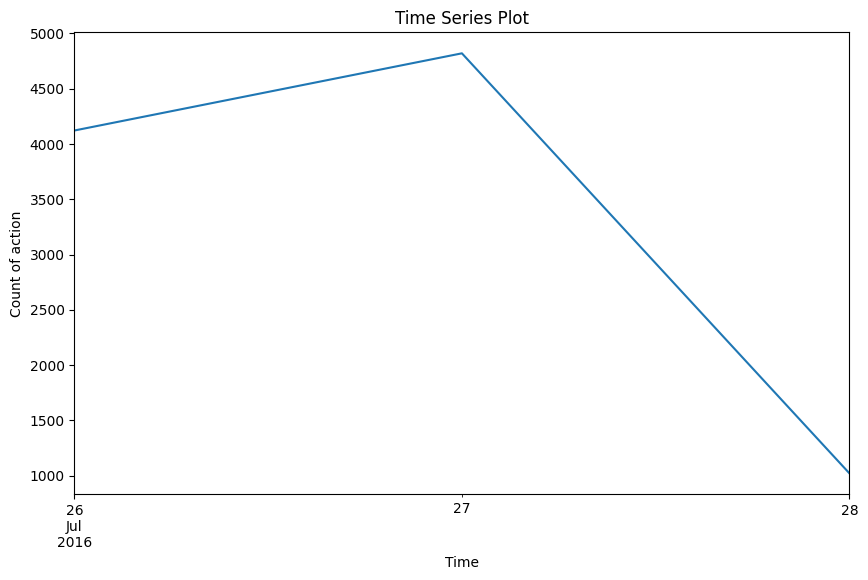

In [0]:
# Visualization Functions
def plot_bar_chart(df, column):
    if df.empty:
        print(f"No data available to plot bar chart for column: {column}")
    else:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=column)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.show()

def plot_time_series(df, time_column, count_column, resample_period='D'):
    if df.empty:
        print(f"No data available to plot time series for column: {time_column}")
        return
    
    try:
        # Convert the time column to datetime format
        # Adjust the format string as per your data's format, or remove it if Pandas can parse it automatically
        df[time_column] = pd.to_datetime(df[time_column], unit='s')  # Assuming Unix timestamp; adjust as needed
        time_series_df = df.set_index(time_column).resample(resample_period)[count_column].count()  # Resample and count the specific column
    except ValueError as e:
        print(f"Error in converting {time_column} to datetime: {e}")
        return

    plt.figure(figsize=(10, 6))
    time_series_df.plot()
    plt.title('Time Series Plot')
    plt.xlabel('Time')
    plt.ylabel(f'Count of {count_column}')
    plt.show()



# Convert to Pandas DataFrame for Visualization
sampling_fraction = 0.1  # Adjust this based on your dataset size
pandas_df = df.sample(fraction=sampling_fraction).toPandas()


# Check if DataFrame is not empty before plotting
if not pandas_df.empty:
    plot_bar_chart(pandas_df, 'action')
    # Example: Counting 'action' occurrences over time
    plot_time_series(pandas_df, 'time', 'action')
else:
    print("DataFrame is empty after sampling. Adjust the sampling fraction or check the source data.")